# Homework 04 - Applied ML

*Remarks for the easy reading of the work*:
The data in use are stored in the folder `Data`, the description is available [here](https://github.com/ADAEPFL/Homework/blob/master/04%20-%20Applied%20ML/DATA.md).
All the functions that are mentioned are stored in separate libraries that are specified at each step. For some of them the reading of the documentation is required to understand how certain results are obtained. 
The *Notebook* organisation is specified in the *Table of contents*.

__Important__: due to the precence of interactive plot, we suggest you to visualize the notebook using the following [link](http://nbviewer.jupyter.org/github/CriMenghini/ADA_Homeworks/blob/master/Homework_4/Hw_4.ipynb).

### Table of contents
1. [Predict the skin color of a soccer player](#task1)
    1. [Exploratory Data Analysis, Feature Selection and Feature engineering](#EDA)
     1. [Target variable](#target)
    2. [Baseline model](#baseline)
	3. [Find the model](#tuning)
	4. [*BONUS*](#bonus)
2. [Cluster players with dark and light skin colors](#task2)
    1. [Sub paragraph](#subparagraph1)

## 1. Predict the skin color of a soccer player <a name="task1"></a>

In this first task we train a *Random forest* classifier to be able to predict the skin color of a soccer player using the player description. In order to do so, we proceed pre-processing the data as first step then moving toward the choice of the model (interpret as the choice of parameters controlling the possible issues i.e. the *overfitting*). As required, we then switch to the inspection of the `feature_importances_` attribute and the discussion of the obtained results.

In [27]:
import os
import plotly
import numpy as np
import pandas as pd
import seaborn as sns  
from plots import *
import plotly.tools as tls
from functools import partial
import matplotlib.pyplot as plt 
from data_preprocessing import *
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import fbeta_score
from tqdm import *
plotly.tools.set_credentials_file(username='crimenghini', api_key='t5q05yuxzu')
%matplotlib inline

In [28]:
# Import data 
data = pd.read_csv('Data/CrowdstormingDataJuly1st.csv', sep = ',')
# Take a look at the data head
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


### A. Exploratory Data Analysis, Feature Selection and Feature engineering <a name="EDA"></a>

### a. Target variable <a name="target"></a>

Before proceeding with the exploration of the features, we focuse our attention on the target variable (`rater1`, `rater2`). In this case we face the folliwing issues:
1. [*Absence of labels*](#absence): Not all the players have an `IDphoto`, thus the *raters* can not label the skin color. It results in a bunch of player not labeled. Since in this first task we work using the *Supervised* learning we drop out all the *dyads* that correspond to players whose picture is not available.

2. [*Inconsistency of labels*](#inconsistency): The labels assigned by the two raters for some players disagree. In order to control this inconsistency we think about different approaches. 
    - Compute the mean of the assigned scores. Whether the classification problem is set up as a *multiclassification* problem (five classes according to the `data description` - 0, 0.25, 0.5, 0.75, 1), if the disagreement of the two classes is greater than 0.25 (absolute value) the computation of the average implies the creation of new classes. Otherwise, whether the classification problem is simplified to the *binary* classification (all those players that have been labeled with $0 < values \leq 0.5$ belong to class 0, all those whose $0.5 < values \leq 1$) the values obtained computing the average can be easily assigned to one of the two classes.
    - Use the two scores vectors to train the model, defining a *multi target* model whether the problem is set up both as *multiclass* or *binary*.
        
3. [*Unbalanced sample*](#unbalance): the sample that we analyse turns to be *unbalanced*. It means that there are classes that are more present in the population. This verification leads to the necessity of using different metrics, rather the *simple* accuracy, to evaluate the model, and can be in some way faced using some tecniques to *rebalance* the sample.

#### 1. Absence of labels  <a name="absence"></a>

In [29]:
# Drop out the unlabeled players
data_clean = data[(data.photoID.notnull())]

Now we are left with the data for the players that have a picture. We want to check whether given the picture both of the raters assuigned the label.

In [30]:
# How many players the rater 1 don't label?
miss_rater_1 = sum(data_clean.rater1.isnull())
# How many the rater 2?
miss_rater_2 = sum(data_clean.rater2.isnull())

print ('Rater 1 does not label', miss_rater_1, 'players')
print ('Rater 2 does not label', miss_rater_2, 'players')

('Rater 1 does not label', 0, 'players')
('Rater 2 does not label', 0, 'players')


We see that both of them label all the players with a picture.

#### 2. Inconsistency of labels <a name="inconsistency"></a>

##### 2.1. Handle `NaNs`
Before analysing the *target* we should control whether there is the precence of `NaN` values, that can eventually lead to the elimitation of players, in the dataset, then we *aggregate* by the player. It is important to check the precence of null values before the aggregation for two reasons:
* It is possible that some dyads do not contain certain values, it does not imply that in the dataset we can not find other dyads that contain the information. Hence, we remove the dyads or, if possible, assign the value (according to the kind of attribute) so that we don't loose the player.
* The precence of `NaN` can cause problems whether an aggregation function is applied. That's because they may propagate.

In [31]:
# Initialize the dictionary {key:value} whose key is the attributed with NaNs and value are the indices
variables_with_nan = {}

# For each attribute
for attribute in data_clean.columns:
    # Check if there are nans
    index_nan = data_clean[attribute].isnull()
    presence_nan = sum(index_nan)
    
    if presence_nan != 0:
        variables_with_nan[attribute] = index_nan

Here the variables with `NaNs` is listed. 

In [32]:
print(variables_with_nan.keys())

['weight', 'meanIAT', 'nExp', 'height', 'nIAT', 'seIAT', 'seExp', 'Alpha_3', 'position', 'meanExp']


We proceed considering the attributes related to the players: `weight`, `height`, `position`.

In [33]:
players_attributes = ['weight', 'height', 'position']

Thus, we clean the dataframe, the documentation related to the function [`remove_nans`](data_preprocessing.py) provides the explanation related to the procedure used to remove `NaNs`.

In [34]:
data_clean = remove_nans(data_clean, variables_with_nan, players_attributes)

We remove ~21% of the dyads, but the number of drop player is controlled by the approach used to remove the `NaNs`. In fact we remove just those player whose important description feature are missing.

In [35]:
print('Number of removed dyads: ', data.shape[0] - data_clean.shape[0])
print('Percentage of the removed dyads: ',round((data.shape[0] - data_clean.shape[0])/(1.0*len(data))*100,2),'%')

('Number of removed dyads: ', 30425)
('Percentage of the removed dyads: ', 20.84, '%')


Then, we aggregate by player and we observe that we proceed the analysis taking into account ~90% of the players.

In [36]:
# Group by the player
player_data = data_clean.groupby('playerShort')

In [37]:
print ('Number of players: ', len(player_data))
print ('Percentage of analysed players: ', round(len(player_data)/(1.0 * 1586)*100, 2), '%')

('Number of players: ', 1419)
('Percentage of analysed players: ', 89.47, '%')


Before using the aggregation functions for some attributes we check whether aggregating we risk to loose some information.

In [38]:
# Check that each player belongs to one club
print ('Each player belongs to: ', player_data.agg({'club' : lambda x: len(set(x))})['club'].unique()[0], 'club.')
# Check that each player registers one position
print ('Each player registers:', player_data.agg({'position' : lambda x: len(set(x))})['position'].unique()[0], 'position.')
# Check that each player registers one weight
print ('Each player registers: ', player_data.agg({'weight' : lambda x: len(set(x))})['weight'].unique()[0], 'weight.')
# Check that each player registers one height
print ('Each player registers: ', player_data.agg({'height' : lambda x: len(set(x))})['height'].unique()[0], 'height.')

('Each player belongs to: ', 1, 'club.')
('Each player registers:', 1, 'position.')
('Each player registers: ', 1.0, 'weight.')
('Each player registers: ', 1.0, 'height.')


In [39]:
# Define the aggregation function
players = player_data.agg({'club' : 'first',
                           'leagueCountry' : 'first',
                           'birthday' : 'first',
                           'height' : 'first',
                           'weight' : 'first',
                           'position' : 'first',
                           'games' : 'sum',
                           'victories' : 'sum',
                           'ties' : 'sum',
                           'defeats' : 'sum',
                           'goals' : 'sum',
                           'yellowCards': 'sum',
                           'yellowReds': 'sum',
                           'redCards' : 'sum',
                           'rater1' : 'mean',
                           'rater2' : 'mean',
                           #'refNum' : 'count',
                           #'refCountry' : 'count',
                           #'meanIAT' : 'mean',
                           #'meanExp' : 'mean'
                          })

In [40]:
players.head()

,rater2,weight,leagueCountry,defeats,club,rater1,height,victories,yellowReds,birthday,games,goals,ties,position,redCards,yellowCards
playerShort,,,,,,,,,,,,,,,,
aaron-hughes,0.00,71.0,England,228,Fulham FC,0.25,182.0,247,0,08.11.1979,654,9,179,Center Back,0,19
aaron-hunt,0.25,73.0,Germany,122,Werder Bremen,0.00,183.0,141,0,04.09.1986,336,62,73,Attacking Midfielder,1,42
aaron-lennon,0.25,63.0,England,115,Tottenham Hotspur,0.25,165.0,200,0,16.04.1987,412,31,97,Right Midfielder,0,11
aaron-ramsey,0.00,76.0,England,68,Arsenal FC,0.00,178.0,150,0,26.12.1990,260,39,42,Center Midfielder,1,31
abdelhamid-el-kaoutari,0.25,73.0,France,43,Montpellier HSC,0.25,180.0,41,4,17.03.1990,124,1,40,Center Back,2,8


##### 2.2. Analyse the target  <a name="rater12"></a>

From the new dataframe we extract the two variables that correspond to the labels.

In [41]:
# Extract labels
label_1 = players['rater1']
label_2 = players['rater2']

We observe that the distribution of the labels related to the two raters are different. It shows the disagreement aforementioned. In particular, the first classifies the 75% of the players as *very light skin*, *light skin*, the number of players classified as *dark skin* or *very dark skin* is so low that the are outside the *Inter-Quartile Range*. The second rated evidence the tendency of giving higher scores. Since we do not have another rater to compare, we can't make an assumption on the reliability of the two.

### INSERT TITLE

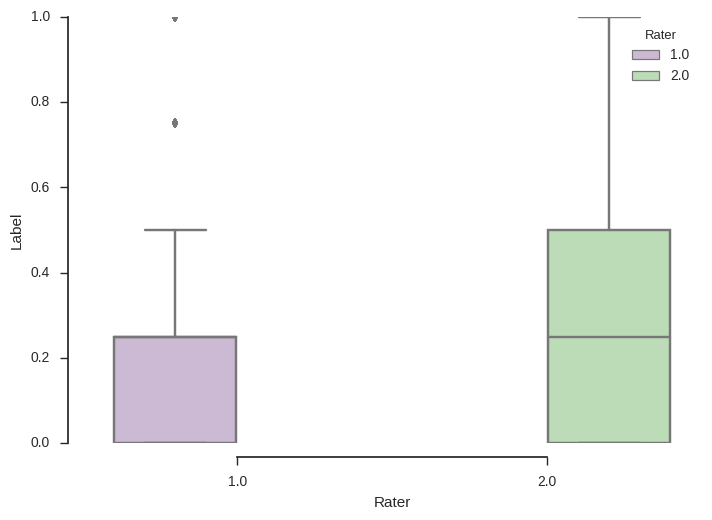

In [42]:
label_boxplot(label_1, label_2)

#### 3. Unbalanced sample <a name="unbalance"></a>

In the view of what we observed in the [previous](#rater12) section, we see that our sample suffers of the lack of samples that are recognized as *dark skin* or *very dark skin*. We show more clearly with the following plot the unbalancement. In particular we see that both the *Rater 1* and *Rater 2* classify in the first three classes more than the 50%.

In [43]:
stacked_plot(label_1,label_2)
tls.embed("https://plot.ly/~crimenghini/0")

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~crimenghini/0 or inside your plot.ly account where it is named 'stacked-bar'


This verification implies important consideration for the further analysis. 
1. We redifine the goal of our analysis as a *Binary Classification* problem. We consider it enough to distinguish a "light skin" player from a "dark skin". In particular the Labels are encoded according to the intervals defined [above](#target). This choice can help us in facing the *unbalancement* of our sample and reduce the complexity of our classification problem. 
2. So far we used the *Accuracy* metric in order to evaluate the accuracy of the model. We will replace it with some other metric. The reason behind it comes from the definition of the accuracy. It is a ratio of the correct prediction over the total sample to predict. Due to the presence of a class (*light skin*) that represents the majority in the sample, the classifier is able to classify this class well. In particular it tends to classify all the observation as that class (we will look at the confusion matrices later). Thus, the accuracy results to be very good just because of the high precence of the class in the data.

Thus, we encode the labels according to the binary classification problem. Before encoding the labels we merge the rates given by the two raters by averaging the scores. The function is stored in [`data_preprocessing`](data_preprocessing.py) library.

In [44]:
label_merged = (label_1 + label_2)/2
labels = label_merged.apply(binary_labels)

In [45]:
players.drop('rater1', axis = 1, inplace = True)

In [46]:
players.drop('rater2', axis= 1, inplace = True)

### Baseline model  <a name="baseline"></a>

1. Use only the variables related to the player.
2. How do we treat the different features:
 1. B-day: just keep the year
 2. Categorization of numerical features when they present more than 12 different values
 3. Encoding of the 'object' attributes according to what is required by the `sklearn`'s `RandomForest` classifier.

#### Preprocess variable to be used as input for the classifier

In [47]:
players['birthday'] = players['birthday'].apply(lambda x: float(x.split('.')[-1]))

In [48]:
# Get the string variables
object_features = [i for i in players.columns if players[i].dtypes == 'object']
numerical_features = [i for i in players.columns if (players[i].dtypes == 'int64' or players[i].dtypes == 'float64') and len(players[i].unique()) > 12]

In [49]:
# Encode strings
for feature in object_features:
    encode_string_variable(players, feature)

In [50]:
# Categorise the numerical features
for i in range(len(numerical_features)):
    players[numerical_features[i]] = players[numerical_features[i]].apply(partial(categorisation, create_bins(players, numerical_features[i])))

#### Split train and test

In [51]:
X_train, X_test, y_train, y_test = train_test_split(players, labels, test_size=0.20, random_state=42)

In [52]:
weight_class = y_train.value_counts()/len(y_train)

In [53]:
weight_class

0    0.839648
1    0.160352
dtype: float64

In [54]:
sample_weights = []
for i in y_train:
    sample_weights += [weight_class[i]]

In [55]:
forest = RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')

In [56]:
train_forest = forest.fit(X_train, y_train, sample_weight= sample_weights)

In [57]:
predict = train_forest.predict(X_test)

In [58]:
train_forest.score(X_test, y_test)

0.83450704225352113

### Find the model <a name="tuning"></a>

#### Cross-validation

We need to check our model in terms of overfitting. In order to do that we perform cross-validation. We will use KFold algorithm.

In [59]:
len(sample_weights)

1135

In [60]:
len(players.iloc[train_index])

NameError: name 'train_index' is not defined

In [ ]:
len(labels.iloc[train_index])

In [ ]:
np.array(players.iloc[test_index])

### *BONUS* <a name="bonus"></a>

## Cluster players with dark and light skin colors <a name="task2"></a>

In this part, we start with the cleaned and grouped player_data used in the previous part, we define the following aggregation function for the features that we categorise as referee information, namely :

* leagueCountry : Where the matche(s) have been refered.
* games : The number of games is close from the number of referees a player has been in contact with.
* victories : Can be highly correlated with a favourable referee.
* defeats : Can be highly correlated with an unfavourable referee.
* goals : An unfavourable referee can result in a lower goal output.
* yellowCards, yellowReds, redCards : Can be highly correlated to an unfavorable referee.
* meanIAT, meanExp: The aggregated data can potientially show how "racist" the referees may have been according to where they come from. 

In [281]:
# Define the aggregation function on the grouped data
ref_agg = player_data.agg({
                           'leagueCountry' : 'first',
                           'games' : 'sum',
                           'victories' : 'sum',
                           'defeats' : 'sum',
                           'goals' : 'sum',
                           'yellowCards': 'sum',
                           'yellowReds': 'sum',
                           'redCards' : 'sum',
                           'rater1' : 'mean',
                           'rater2' : 'mean',
                           'meanIAT' : 'mean',
                           'meanExp' : 'mean',
                          })

Checking the aggregated data:

In [284]:
ref_agg.sample(5)

,yellowReds,goals,meanExp,rater2,leagueCountry,defeats,meanIAT,rater1,victories,games,redCards,yellowCards
playerShort,,,,,,,,,,,,
chahir-belghazouani,0,12,0.366080,0.50,France,39,0.331207,0.50,32,104,0,28
bodipo,1,41,0.509340,0.25,Spain,100,0.354025,0.50,67,220,3,28
martin-kelly,0,3,0.479849,0.25,England,17,0.347450,0.00,41,73,0,6
niclas-fuellkrug,0,36,0.354456,0.25,Germany,44,0.338289,0.00,38,106,0,4
adrian_7,0,0,0.588297,0.25,Spain,8,0.369894,0.25,10,29,0,3


Reorder the columns for preprocessing :

In [286]:
cols = ['rater1', 'rater2','leagueCountry', 'games', 'victories', 'defeats','goals', 'yellowCards', 'yellowReds', 'redCards', 'meanIAT', 'meanExp']
ref_agg = ref_agg[cols]

Encode the string features :

In [287]:
# Encode strings
encode_string_variable(ref_agg, 'leagueCountry')

Drop the labels of the data :

In [288]:
ref_nolabels = ref_agg.drop(['rater1', 'rater2'], axis=1)

In [289]:
ref_nolabels.sample(5)

,leagueCountry,games,victories,defeats,goals,yellowCards,yellowReds,redCards,meanIAT,meanExp
playerShort,,,,,,,,,,
eren-derdiyok,2,288,133,84,70,27,1,0,0.345404,0.456015
jack-wilshere,0,165,93,44,11,25,1,1,0.343584,0.446713
kevin-mirallas,0,335,154,92,79,36,0,2,0.342654,0.466444
pedro-leon,3,198,71,87,30,35,1,1,0.361431,0.558427
jamel-saihi,1,120,59,32,2,26,0,2,0.320057,0.287033


Standardize the data :

In [263]:
ref_std = np.array(preprocessing.scale(ref_nolabels))

Create better labels by taking the mean of the two raters and then apply a binarisation function :

In [292]:
ref_agg['meanRaters'] = (ref_agg['rater1'] + ref_agg['rater2'])/2
ref_agg['meanRaters'] = ref_agg['meanRaters'].apply(binary_labels)
labels = ref_agg['meanRaters']

Definition of a helper function for label inversion and vectorize it for use on numpy arrays :

In [293]:
def invert_labels(x):
    if(x==1):
        return 0
    else:
        return 1
v = np.vectorize(invert_labels)

# Baseline clustering
A first try at clustering using all the features of the referee information.

In [296]:
#first clustering with all columns
kmeans = KMeans(n_clusters=2).fit(ref_std)
#predictions:
pred = kmeans.labels_

We then compute the f-beta score of the clustering with an inclination for recall.

In [299]:
#f-beta score import
from sklearn import metrics

In [300]:
#f-beta score for the predictions
metrics.silhouette_score(ref_std, pred, metric='euclidean')

0.28944428959313273

We also look at the f-beta score of the inverted predictions because they do not represent the belonging to a skin color cluster but to a cluster.

In [301]:
#f-beta score for the inverted predictions
metrics.silhouette_score(ref_std, v(pred), metric='euclidean')

0.28944428959313273

Here we have a really low f-score, let's try to improve the clusterisation by trying different features combinations.

In [302]:
#Importing itertool to create combinatorics
import itertools as iter

Create an array of column indexes for the feature selection.

In [303]:
columns = [i for i in range(0,ref_std.shape[1])]

Initialise storage variables for the future iterative process.

In [304]:
features = []
silhouettes = []
silhouettes_inv = []
f_scores = []
f_scores_inv = []

# Trying features combinations:

In the next cell we try every possible combination of 2-8 features for the clutering. We allow ourselves to perform this heavy computation because our dataset is of reasonable size. At each iteration, we perform the clustering and then store the silhouette score, the f-beta score, the inverted f-beta score (with inverted predictions) and the feature combination used to obtain the clustering. While waiting for the computation, you can enjoy the nice looking and informative progress bars.

In [305]:
for i in tqdm_notebook(range(1, ref_std.shape[1]-1), desc='Global'):
    #generate combination of features 
    combinations = list(iter.combinations(columns, len(columns)-i))
    #Iterate over every combination
    for comb in tqdm_notebook(combinations, desc='Combining', leave=False) :
        #Clustering
        kmeans = KMeans(n_clusters=2, random_state=1).fit(ref_std[:, comb])
        #Extract labels
        pred = kmeans.labels_
        #Silhouette and f-beta score for predictions
        silhouettes.append(metrics.silhouette_score(ref_std[:, comb], pred, metric='euclidean'))
        f_scores.append(fbeta_score(labels, pred, beta=1.9)) 
        #Silhouette and f-beta score for inverted predictions
        inv_pred = v(pred)
        silhouettes_inv.append(metrics.silhouette_score(ref_std[:, comb], inv_pred, metric='euclidean'))
        f_scores_inv.append(fbeta_score(labels, inv_pred, beta=1.9))
        #Store feature combination
        features.append(comb)

In the next part we will analize the data obtained previously, let's take a look at the scatterplot of f-score and silhouette.

In [401]:
triples = zip(silhouettes,f_scores, features)
points = np.array(zip(silhouettes, f_scores))

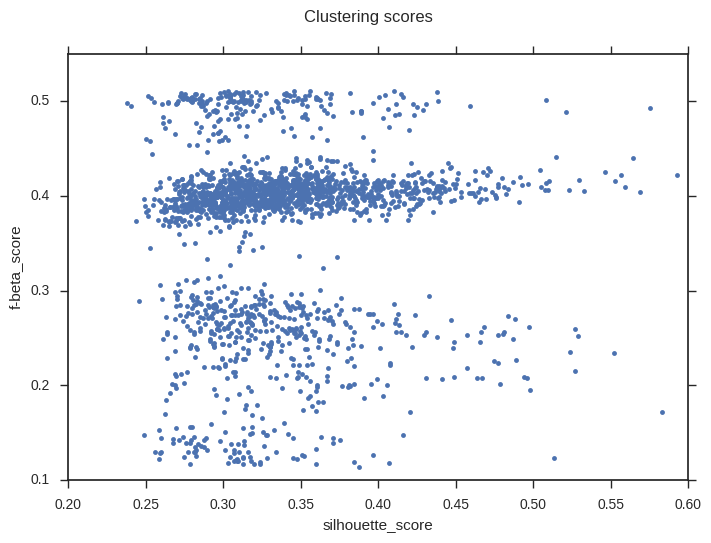

In [402]:
fig1 = plt.figure()
plt.plot(points[:,0], points[:,1], '.')
fig1.suptitle('Clustering scores')
plt.xlabel('silhouette_score')
plt.ylabel('f-beta_score')

After a quick glance at the plot we can see that the f-beta score doesn't go above 0.6, meaning that there is no combination of referee related features that yield a good White/Black clustering. But we still want to see what are the best feature combinations possible regarding clustering, we also want to visualise the accuracy/silhouette tradeoff.

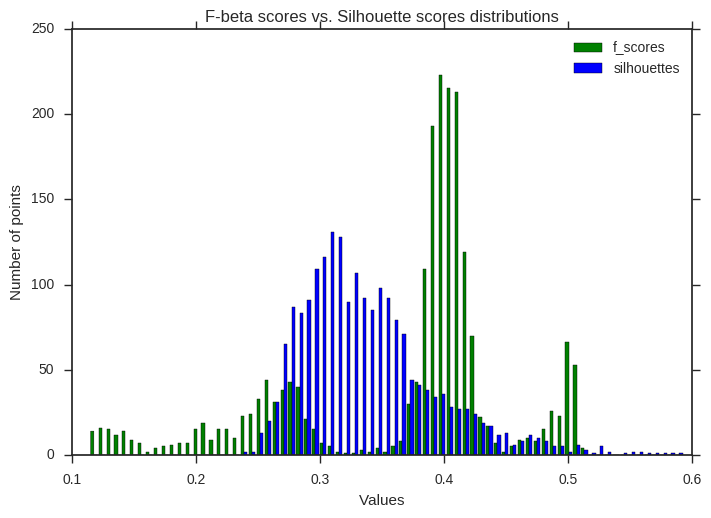

In [403]:
from scipy.stats import norm
import pylab as P
import matplotlib.mlab as mlab


colors = ['green', 'blue']
labels = ['f_scores', 'silhouettes']
n, bins, patches = P.hist([f_scores, silhouettes], 75,histtype='bar',
                            color=colors,
                            label=labels)
P.legend()
plt.xlabel('Values')
plt.ylabel('Number of points')
plt.title('F-beta scores vs. Silhouette scores distributions')

Here we see that indeed there is a clear tradeoff between f-beta scores and silhouette scores. We would like now to find the best points in terms of f-beta score and silhouette score.

First we select only the points above 0.4 both for f-beta score and silhouette score.

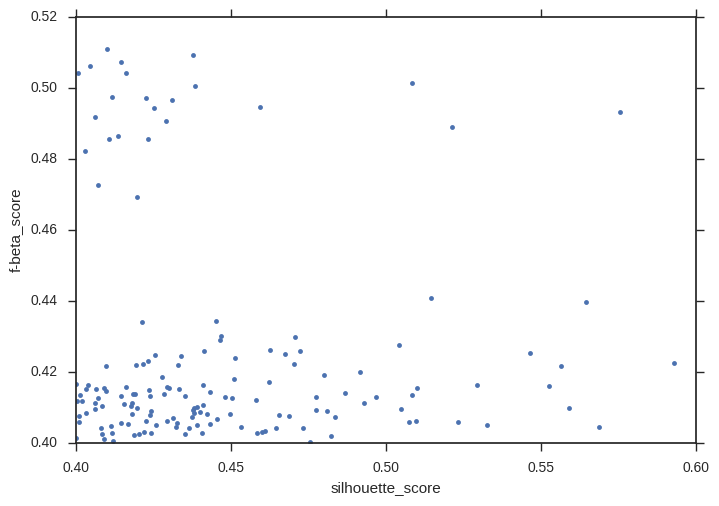

In [404]:
bestpoints = points[(points[:,0] > 0.4) & (points[:,1] > 0.4)]
plt.plot(bestpoints[:,0], bestpoints[:,1], '.')
fig1.suptitle('Clustering scores')
plt.xlabel('silhouette_score')
plt.ylabel('f-beta_score')

Then, in order to select the best points, we compute the convex hull :

In [405]:
from scipy.spatial import ConvexHull
hull = ConvexHull(bestpoints)

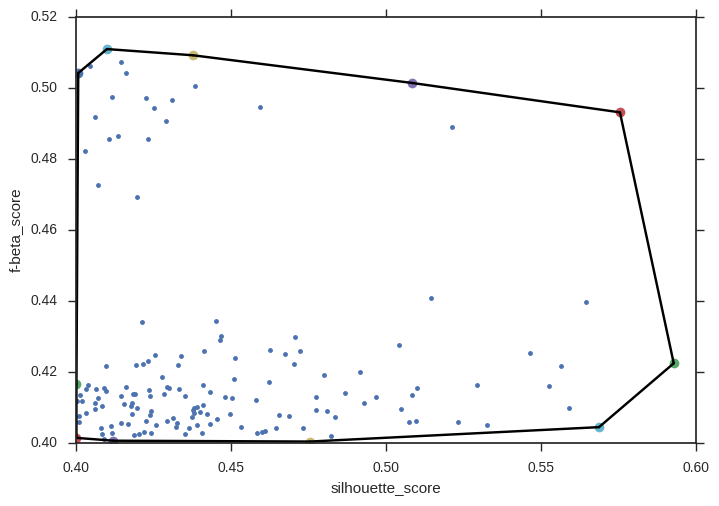

In [406]:
fig2 = plt.figure()
fig1.suptitle('Convex Hull')
plt.xlabel('silhouette_score')
plt.ylabel('f-beta_score')
plt.plot(bestpoints[:,0], bestpoints[:,1], '.')
for vertex in hull.vertices:
    plt.plot(bestpoints[vertex, 0], bestpoints[vertex, 1], 'o')
for simplex in hull.simplices:
    plt.plot(bestpoints[simplex, 0], bestpoints[simplex, 1], 'k-')

In [407]:
sel = []
for vertex in hull.vertices:
    sel.append([bestpoints[vertex, 0], bestpoints[vertex, 1]])
sel = np.array(sel)
sel = sel[sel[:,1]>0.48]

In [408]:
coordinates = zip(silhouettes, f_scores, features)
results = [r for r in coordinates if np.array(r[0], r[1]) in sel]
results

[(0.4007228631008366, 0.50416554535720626, (0, 4, 9, 10)),
 (0.43774736400046965, 0.50915323295965009, (0, 5, 9, 10)),
 (0.4099916501918256, 0.5109006216557862, (0, 6, 9, 10)),
 (0.50851982245175953, 0.5013509150537816, (0, 9)),
 (0.57546600233498424, 0.49308708150254937, (9, 10))]

In [409]:
col_names = np.array(ref_nolabels.columns)

In [418]:
for i in results:
    print(col_names[np.array(i[2])])

IndexError: index 10 is out of bounds for axis 1 with size 10